In [1]:
import sys
print sys.prefix
print sys.version

c:\anaconda2\envs\mypy
2.7.12 |Continuum Analytics, Inc.| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


In [2]:
import waves_utils as wu
from time import gmtime, strftime
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Building the matrices of waves for all cases available

In [3]:
db_dir = "D:/tmp/IPYNBv2/eds"
waves_u = wu.WavesUtilities(['HR', 'RR', 'ABPS', 'ABPD'], None, db_dir)

nb_pts = 96

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
# pr = waves_u.build_pyriemann_input_matrix(nb_splits, nb_pts)
pr = waves_u.build_pyriemann_input_matrix_one_shot(nb_pts)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
pr_3d_matrix = pr[0]
tgt_vector = pr[1]
ids_vector = np.array(pr[2])

2016-11-01 11:28:55
loading rows from db...
done
1 keys processed
301 keys processed
601 keys processed
901 keys processed
case 00087732812016-01-22 removed (not enough meaningful values)
1201 keys processed
2016-11-01 11:37:44


In [4]:
# Save 3D matrix in file
np.save("icu_matrix5.pyriemann", pr_3d_matrix)
np.save("icu_target5.pyriemann", tgt_vector)
np.save("icu_ids5.pyriemann", ids_vector)

mat = np.load("icu_matrix5.pyriemann.npy")

print(np.array_equal(pr_3d_matrix, mat))

wds = wu.WaveDataset(['HR', 'RR', 'ABPS', 'ABPD'], 5, estimator='oas')

True


# Plot several cases

519


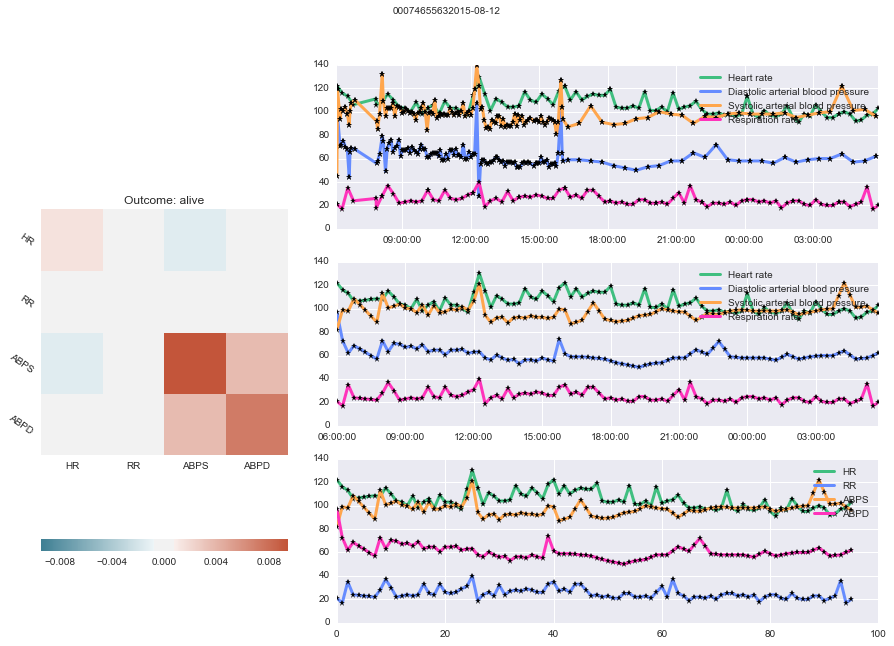

In [5]:
id_case = np.random.randint(mat.shape[0])
print(id_case)
wds.case_figure(id_case)

963


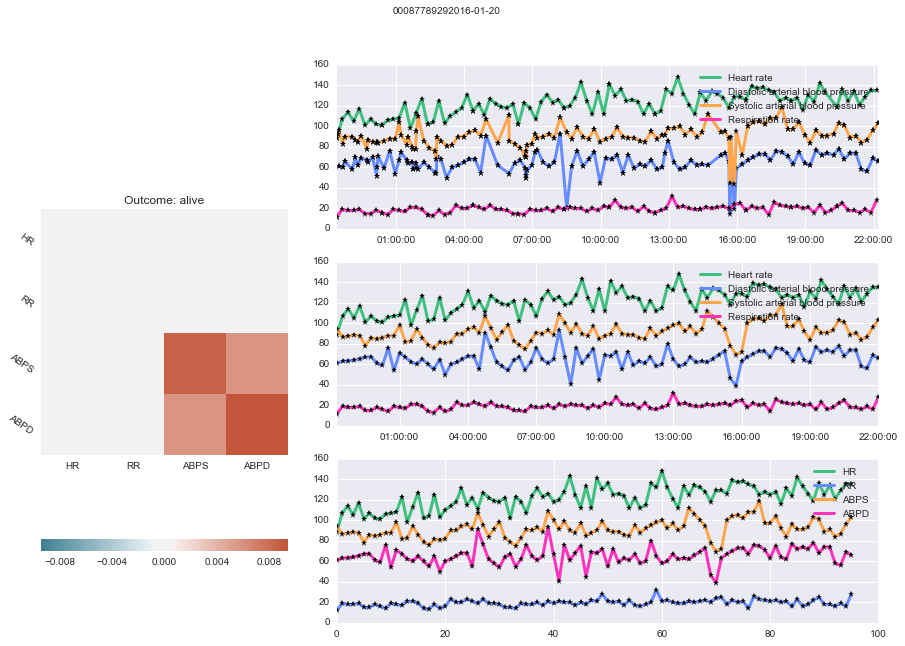

In [6]:
id_case = np.random.randint(mat.shape[0])
print(id_case)
wds.case_figure(id_case)

# Spectral analysis

759


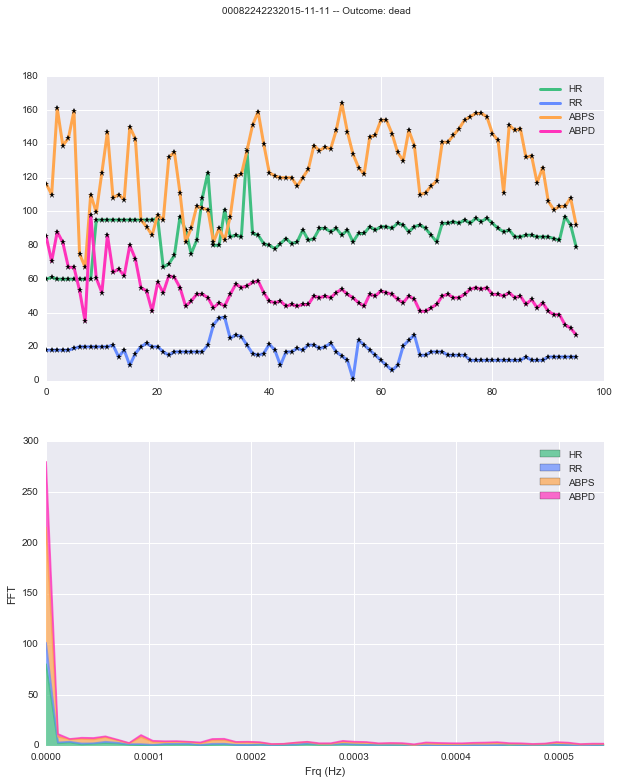

In [21]:
id_case = np.random.randint(mat.shape[0])
print(id_case)
wds.case_figure_spectrum(id_case)

842


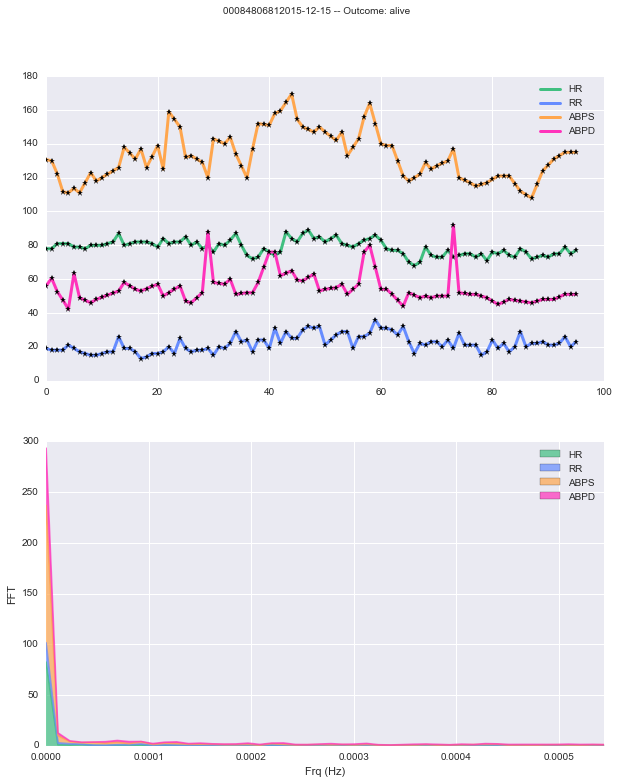

In [22]:
id_case = np.random.randint(mat.shape[0])
print(id_case)
wds.case_figure_spectrum(id_case)

# Plot mean covariance matrices by class

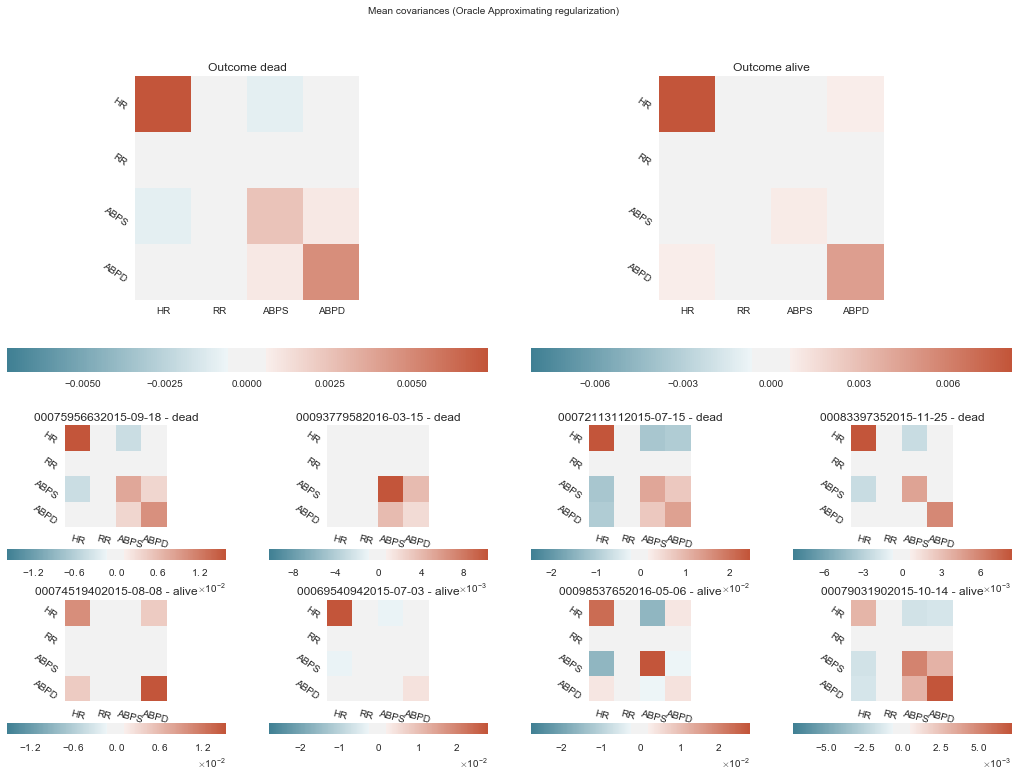

In [7]:
wds.mean_cov_plot_by_class(metric='riemann', add_examples=True)

# Check for covariances influence

In [15]:
# Load set of waves
# Load Matrice and target
X = np.load("icu_matrix5.pyriemann.npy")
y_true = np.load("icu_target5.pyriemann.npy")
print y_true
print(len(y_true[y_true==True]))
X.shape, np.size(y_true)

[ True  True False ..., False False False]
269


((1445L, 4L, 96L), 1445)

In [16]:
# Mortality
print(len(y_true[y_true==True]))
print(float(len(y_true[y_true==True])) / float(len(y_true))* 100.)

269
18.615916955


In [17]:
# Min-Max values normalization
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
for case in range(X.shape[0]):
    X[case] = MinMaxScaler().fit_transform(X[case])
    
import pyriemann
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM, FgMDM
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# estimate covariances matrices
cov = pyriemann.estimation.Covariances(estimator='scm').fit_transform(X)
cov.shape

(1445L, 4L, 4L)

In [18]:
import classif_utilities as cu
# Separate train / validation
X_train, y_train, X_valid, y_valid = cu.split_dataset(cov, y_true)

In [19]:
from sklearn.linear_model import LogisticRegression

# Reg log test 1 (keep only variances)

X1_train = np.zeros((X_train.shape[0], X_train.shape[1]))
for case in range(X_train.shape[0]):
    X1_train[case] = np.diag(X_train[case])
    
X1_valid = np.zeros((X_valid.shape[0], X_valid.shape[1]))
for case in range(X_valid.shape[0]):
    X1_valid[case] = np.diag(X_valid[case])
    
lr1 = LogisticRegression(n_jobs=-1)
print("Cross validation, accuracies")
print(cu.cross_valid_clf(lr1, X1_train, y_train))
print("Validation set ==> accuracy + recall + precision + ROC/AUC score")
print(cu.validate_clf(lr1, X1_train, y_train, X1_valid, y_valid))

Cross validation, accuracies
[ 0.8134715   0.8134715   0.8134715   0.8134715   0.81675393]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.81327800829875518, 0.0, 0.0, 0.59951814058956909)


In [20]:
# Reg log test 2 (keep variances and covariances)
X2_train = np.zeros((X_train.shape[0], X_train.shape[1]*(X_train.shape[1]+1)/2))
for case in range(X_train.shape[0]):
    tri = X_train[case]
    tri[tri == 0] = np.nan
    tri = np.ravel(np.tril(tri).T)
    tri = tri[np.where(tri!=0)[0]]
    tri = np.nan_to_num(tri)
    X2_train[case] = tri
    
X2_valid = np.zeros((X_valid.shape[0], X_valid.shape[1]*(X_valid.shape[1]+1)/2))
for case in range(X_valid.shape[0]):
    tri = X_valid[case]
    tri[tri == 0] = np.nan
    tri = np.ravel(np.tril(tri).T)
    tri = tri[np.where(tri!=0)[0]]
    tri = np.nan_to_num(tri)
    X2_valid[case] = tri
    
lr2 = LogisticRegression(n_jobs=-1)
print("Cross validation, accuracies")
print(cu.cross_valid_clf(lr2, X2_train, y_train))
print("Validation set ==> accuracy + recall + precision + ROC/AUC score")
print(cu.validate_clf(lr2, X2_train, y_train, X2_valid, y_valid))

Cross validation, accuracies
[ 0.8134715   0.8134715   0.8134715   0.8134715   0.81675393]
Validation set ==> accuracy + recall + precision + ROC/AUC score
(0.81327800829875518, 0.0, 0.0, 0.60308956916099776)
